<a href="https://colab.research.google.com/github/jenmusdat/Project3_BeerQuality/blob/main/Analysis/Jenny_WordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

!echo "spark.driver.memory 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!echo "spark.executor.memory 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!echo "spark.driver.maxResultSize 5g" >> $SPARK_HOME/conf/spark-defaults.conf
!cat $SPARK_HOME/conf/spark-defaults.conf

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()
# MAX_MEMORY='5g'
# spark = SparkSession \
#     .builder \
#     .appName("word2vec") \
#     .config("spark.executor.memory", MAX_MEMORY) \
#     .config("spark.driver.memory", MAX_MEMORY) \
#     .getOrCreate()

In [4]:
# Import needed libs
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec, Word2VecModel
import string


In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="/content/gdrive/MyDrive/x/reviews_beer_brewery.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("reviews_beer_brewery.csv"), header=True)

# Show DataFrame
df.show()

+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----+----------+--------------------+---------------+-------------+-----------------+
|beer_id|        username|      date|                text|                look|               smell|               taste|                feel|             overall|               score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|   brewery_city|brewery_state|    brewery_types|
+-------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----+----------+--------------------+-----------

In [6]:
# Check the schema for numeric conversion
df.printSchema

<bound method DataFrame.printSchema of DataFrame[beer_id: string, username: string, date: string, text: string, look: string, smell: string, taste: string, feel: string, overall: string, score: string, beer_name: string, review_state: string, style: string, availability: string, abv: string, brewery_id: string, brewery_name: string, brewery_city: string, brewery_state: string, brewery_types: string]>

In [7]:
df.count()

2127677

In [8]:
# remove alpha characters from data set on review numerics
from pyspark.sql.functions import regexp_extract, col
pattern = r'^\d+.\d+$'
df = df.filter(regexp_extract(col('look'), pattern, 0) != '')
df = df.filter(regexp_extract(col('smell'), pattern, 0) != '')
df = df.filter(regexp_extract(col('taste'), pattern, 0) != '')
df = df.filter(regexp_extract(col('feel'), pattern, 0) != '')
df = df.filter(regexp_extract(col('overall'), pattern, 0) != '')
df = df.filter(regexp_extract(col('score'), pattern, 0) != '')

In [9]:
# confirm look, smell, taste, overall, and score
df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+
| 271781|    bluejacket74|2017-03-17|   750 ml bottle,...| 4.0|  4.0|  4.0|4.25|    4.0| 4.03|Motorbreath Imper...|          OH|American Imperial...|Limited (brewed o...|10.8|     28094|Four String Brewi...|    Columbus|           OH| Brewery, Bar|
| 18

In [10]:
df.count()

1973273

In [11]:
# Next 6 lines casts to floats all the review ratings
df = df.withColumn('look_numeric', df['look'].cast('float'))
df = df.withColumn('smell_numeric', df['smell'].cast('float'))
df = df.withColumn('taste_numeric', df['taste'].cast('float'))
df = df.withColumn('feel_numeric', df['feel'].cast('float'))
df = df.withColumn('overall_numeric', df['overall'].cast('float'))
df = df.withColumn('score_numeric', df['score'].cast('float'))

In [12]:
# Confirm data types
df.printSchema

<bound method DataFrame.printSchema of DataFrame[beer_id: string, username: string, date: string, text: string, look: string, smell: string, taste: string, feel: string, overall: string, score: string, beer_name: string, review_state: string, style: string, availability: string, abv: string, brewery_id: string, brewery_name: string, brewery_city: string, brewery_state: string, brewery_types: string, look_numeric: float, smell_numeric: float, taste_numeric: float, feel_numeric: float, overall_numeric: float, score_numeric: float]>

In [13]:
# functions for manipulating review text into a format we can tokenize
def remove_punctuation(txt):
  txt = txt.strip('\xa0\xa0 ')
  return "".join(l if l not in string.punctuation else "" for l in txt)

def remove_space (text):
  if text:
    return text.replace(' ', '')
  else:
    return 'Unknown'
  

In [14]:
# define the udfs for the data
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

remove_space_udf = udf(remove_space, StringType())
remove_space_udf

<function __main__.remove_space>

In [15]:
# clean the beer name by removing spaces (will be combined with text)
beer_df = df.withColumn('beer_clean', remove_space_udf(col('beer_name')))
beer_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+---

In [16]:
# clean the style name by removing spaces (will be combined with text)
style_df = beer_df.withColumn('style_clean', remove_space_udf(col('style')))
style_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+--

In [17]:
# clean the text by removing punctuation
text_df = style_df.withColumn("clean_text", remove_punctuation_udf(col("text")))
text_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|          clean_text|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+-

In [18]:
text_df = text_df.filter('clean_text != "0"')
text_df.count()

1938698

In [19]:
# Combine beer_name, style, and review text into a Final_text column
# from pyspark.sql.functions import concat_ws

#combined_df = text_df.withColumn('Final_text', concat_ws(' ',text_df.beer_clean, text_df.style_clean, text_df.clean_text))
#combined_df.select('text', 'Final_text').show(truncate=False)

In [20]:
wordcount_df = text_df.select('clean_text')

In [21]:
wordcount_df.show()

+--------------------+
|          clean_text|
+--------------------+
|750 ml bottle 201...|
|Clear gold in col...|
|Reminds me of pre...|
|Pale yellow body ...|
|The CANQuest tm i...|
|I got a Payback P...|
|Enjoyed from the ...|
|Pours a golden ye...|
|This thing is gor...|
|   16oz draft A D...|
|The chipotle pepp...|
|I want this porte...|
|12 FL OZ bottle S...|
|pretty good for i...|
|I bought a 6pck a...|
|Pours a medium br...|
|12 ounce can into...|
|Porter first and ...|
|Aroma is fudgy wi...|
|Yum good ohio bee...|
+--------------------+
only showing top 20 rows



In [22]:
wordcount_df = wordcount_df.select('clean_text').toPandas()

In [23]:
import pandas as pd
len(wordcount_df)


1938698

In [40]:
reduce_df = wordcount_df.loc[0:600000,:]
len(reduce_df)

600001

In [41]:
import pandas as pd

out = ' '.join(reduce_df["clean_text"])

In [30]:
print(out)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



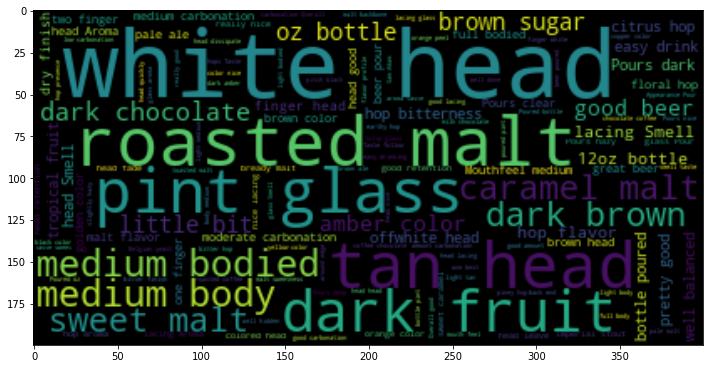

In [42]:
from wordcloud import WordCloud
#wcloud = WordCloud().generate_from_frequencies(frequency_dist)
#plotting the wordcloud
wcloud = WordCloud().generate(out)
import matplotlib.pyplot as plt 
fig=plt.figure(figsize=(12,8))
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

In [20]:
# Setup and execute Tokenizer and Stop words pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(text_df)
final_df = pipeline_stg.transform(text_df)
final_df.show()

+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+------------+--------------------+--------------------+----+----------+--------------------+------------+-------------+-------------+------------+-------------+-------------+------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|beer_id|        username|      date|                text|look|smell|taste|feel|overall|score|           beer_name|review_state|               style|        availability| abv|brewery_id|        brewery_name|brewery_city|brewery_state|brewery_types|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|          beer_clean|         style_clean|          clean_text|          token_text|            features|
+-------+----------------+----------+--------------------+----+-----+-----+----+-------+-----+--------------------+---------

In [21]:
# Create a df that had only the columns needed, leaving final text in this version for clustering later
compare_df = final_df.select('look_numeric', 'smell_numeric', 'taste_numeric', 'feel_numeric', 'overall_numeric', 'score_numeric','features')

In [22]:
compare_df.show()

+------------+-------------+-------------+------------+---------------+-------------+--------------------+
|look_numeric|smell_numeric|taste_numeric|feel_numeric|overall_numeric|score_numeric|            features|
+------------+-------------+-------------+------------+---------------+-------------+--------------------+
|         4.0|          4.0|          4.0|        4.25|            4.0|         4.03|[750, ml, bottle,...|
|         4.0|          4.0|          3.5|         3.5|           3.75|          3.7|[clear, gold, col...|
|         4.0|          4.0|         4.25|        3.75|            4.0|         4.08|[reminds, pretty,...|
|        3.25|         3.25|          3.5|         3.5|            3.5|         3.43|[pale, yellow, bo...|
|        3.75|         3.75|          3.5|         3.5|            3.5|         3.58|[canquest, tm, ho...|
|        3.75|          3.5|          3.5|         3.5|            3.5|         3.52|[got, payback, pi...|
|        3.75|         3.25|         

In [23]:
# Convert the df to pandas to use sklearn
compare_df = compare_df.select('features').toPandas()
#pandas_predictions_df = predictions.select('features','prediction').toPandas()

In [29]:
import pandas as pd

compare_df.head()

,features
0,"[750, ml, bottle, 2016, vintage, bottle, 304, ..."
1,"[clear, gold, color, light, head, little, laci..."
2,"[reminds, pretty, much, every, czech, pilsner,..."
3,"[pale, yellow, body, wispy, white, head, faint..."
4,"[canquest, tm, honored, add, anything, four, s..."


In [32]:
import sys
import codecs
import nltk
from nltk.corpus import stopwords

words = compare_df
words.index = words.index.str.encode('utf-8')

AttributeError: ignored

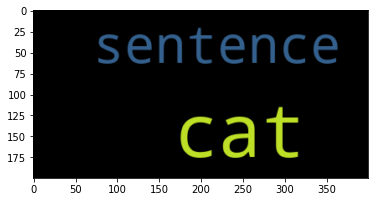

In [33]:
from wordcloud import WordCloud
#wcloud = WordCloud().generate_from_frequencies(frequency_dist)
#plotting the wordcloud
wcloud = WordCloud().generate('This is a sentence a sentence cat cat cat cat cat.')
import matplotlib.pyplot as plt 
plt.imshow(wcloud, interpolation='bilinear')
plt.show()


In [28]:
import sys
import codecs
import nltk
from nltk.corpus import stopwords

words = compare_df
# words.index = words.index.str.encode('utf-8')
# Remove single-character tokens (mostly punctuation)
words = [word for word in words if len(word) > 1]

# Remove numbers
words = [word for word in words if not word.isnumeric()]

# Calculate frequency distribution
fdist = nltk.FreqDist(words)

# Output top 50 words
for word, frequency in compare_df.most_common(50):
    print(u'{};{}'.format(word, frequency))

TypeError: ignored

In [ ]:
#
# Next 5 cells commented out because we already generated the model
#


# Create w2v model hyperparameters
#word2vec = Word2Vec(
#    vectorSize=65,
#    seed=42,
#    inputCol="features",
#    outputCol="model"
#).setMaxIter(2)

In [ ]:
# Fit the model, this takes time
#w2v_review_model = word2vec.fit(final_df)

In [ ]:
# show some model vectors
#w2v_review_model.getVectors().show()

+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|               mells|[0.03909590840339...|
|             tasties|[0.09013923257589...|
|    sidebysidebyside|[0.20330214500427...|
|        morph3/10/15|[-0.0720658451318...|
|              profle|[-0.0295072738081...|
|           professed|[-0.0607991032302...|
|            macdaddy|[-0.0618058256804...|
|brewer'spaleale(n...|[-0.2465905994176...|
|               31211|[-0.1716884523630...|
|palmettohopharves...|[-0.0251995716243...|
|  experimentalj-hole|[-0.0857357680797...|
|          machfive55|[-0.1270782351493...|
|              300day|[0.03120961971580...|
|          iteresting|[-0.0693334937095...|
|          fivehopipa|[-0.2610330283641...|
|               chary|[0.00651914766058...|
|          nonfruited|[0.34797608852386...|
|       eyewateringly|[0.15294347703456...|
|100barrelseries#2...|[-0.1572935581207...|
|               motts|[0.2009695

In [ ]:
# check the model accuracy by checking synonyms 
#w2v_review_model.findSynonymsArray("light", 5)

[('medium', 0.6870060563087463),
 ('ligh', 0.6730795502662659),
 ('slight', 0.661352813243866),
 ('mild', 0.6593009829521179),
 ('mostly', 0.6529689431190491)]

In [ ]:
# write the model to disk
#w2v_review_model.write().overwrite().save("/content/gdrive/MyDrive/Project3_BeerQuality/review.md")

In [ ]:
# Read the model from disk to confirm
w2v_loaded_model = Word2VecModel.load('/content/gdrive/MyDrive/x/review.md')

In [ ]:
# check to see if synonym is consistent with loaded model
w2v_loaded_model.findSynonymsArray("light", 5)

[('medium', 0.6914238929748535),
 ('mostly', 0.6894241571426392),
 ('ligh', 0.6799790859222412),
 ('slight', 0.6678677201271057),
 ('mild', 0.6617092490196228)]

In [ ]:
# Transform the mode
w2v_model_df = w2v_loaded_model.transform(compare_df)

In [ ]:
w2v_model_df.show(truncate=False)

+------------+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
w2v_model_df = w2v_model_df.select('look_numeric','overall_numeric', 'model', 'Features')

In [ ]:
# Remove features to slim down the df (memory)
w2v_model_df = w2v_model_df.select('look_numeric','overall_numeric', 'model', 'Final_text')

In [ ]:
#  Force the df into memory for faster processing
w2v_model_df.cache()
w2v_model_df.show()

+------------+---------------+--------------------+--------------------+
|look_numeric|overall_numeric|               model|            Features|
+------------+---------------+--------------------+--------------------+
|         4.0|            4.0|[0.01448507781083...|[motorbreathimper...|
|         4.0|           3.75|[-0.0253503741696...|[paybackpilsner, ...|
|         4.0|            4.0|[0.18410651786969...|[paybackpilsner, ...|
|        3.25|            3.5|[0.06293463234656...|[paybackpilsner, ...|
|        3.75|            3.5|[0.05097741415932...|[paybackpilsner, ...|
|        3.75|            3.5|[-0.0508729857910...|[paybackpilsner, ...|
|        3.75|            3.5|[0.00700588056351...|[paybackpilsner, ...|
|        3.75|           3.75|[0.05808807828245...|[paybackpilsner, ...|
|         4.5|           3.75|[0.00684954653171...|[paybackpilsner, ...|
|         3.5|            3.5|[0.03865336287325...|[hellhammer, ryeb...|
|        4.25|           4.25|[-0.0377690620720...|

In [ ]:
# just grab what you need for linear regression
split_df = w2v_model_df.select('look_numeric', 'overall_numeric', 'model')

In [ ]:
# split training and testing for the model (for temporary make the training set small as processing takes time)
training, testing = split_df.randomSplit([0.60, 0.40])

In [ ]:
training.show()

+------------+---------------+--------------------+
|look_numeric|overall_numeric|               model|
+------------+---------------+--------------------+
|         1.0|            1.0|[-0.1294552323718...|
|         1.0|            1.0|[-0.1238862046040...|
|         1.0|            1.0|[-0.1036582394236...|
|         1.0|            1.0|[-0.0947362417562...|
|         1.0|            1.0|[-0.0939474090312...|
|         1.0|            1.0|[-0.0644979940970...|
|         1.0|            1.0|[-0.0475221207617...|
|         1.0|            1.0|[-0.0446819979697...|
|         1.0|            1.0|[-0.0376300061121...|
|         1.0|            1.0|[-0.0371596331129...|
|         1.0|            1.0|[-0.0328653222666...|
|         1.0|            1.0|[-0.0308182146400...|
|         1.0|            1.0|[-0.0239243041723...|
|         1.0|            1.0|[-0.0167301403554...|
|         1.0|            1.0|[-0.0147256499816...|
|         1.0|            1.0|[-0.0141140275651...|
|         1.

In [ ]:
# Convert the df to pandas to use sklearn
training_pandas_df = training.toPandas()

In [ ]:
# Show the pandas df
training_pandas_df.head()

,look_numeric,overall_numeric,model
0,1.0,1.0,"[-0.11572664380073548, -0.21177025735378266, 0..."
1,1.0,1.0,"[-0.10028996070226033, 0.18440489346782366, 0...."
2,1.0,1.0,"[-0.07294917111662594, 0.021757342733090393, -..."
3,1.0,1.0,"[-0.06884158278505007, -0.10826455677549043, 0..."
4,1.0,1.0,"[-0.05344004978766092, 6.428283030310503e-05, ..."


In [ ]:
training_pandas_df.dtypes

look_numeric       float32
overall_numeric    float32
model               object
dtype: object

In [ ]:
# Create the linear regression model
from sklearn.linear_model import LinearRegression
pandas_lin_model = LinearRegression()

In [ ]:
# Fit the overall rating into the model
lin_overall_train_model = pandas_lin_model.fit(training_pandas_df['model'].to_list(),training_pandas_df['overall_numeric'])

In [ ]:
# Verify the score, very low so no strong correlation between w2v model and overall rating
lin_overall_train_model.score(training_pandas_df['model'].to_list(), training_pandas_df['overall_numeric'])

0.3375217748898433

In [ ]:
# Show the coeficients
lin_overall_train_model.coef_

array([ 0.41727962, -0.81956002,  0.78890646, -0.3738341 ,  0.27483688,
        0.45247975, -0.74408259,  0.12316563, -0.20045468, -1.13727605,
        0.64433967, -0.85277644, -0.43520227,  1.07692614,  0.26800847,
       -0.10140362, -0.9323706 ,  0.87645293,  0.54445274,  0.08426406,
        0.1366568 , -1.23732701, -0.99848742,  0.38115628,  0.84200813,
        1.11184976, -0.45912076,  0.0509642 ,  0.33798579, -1.63957888,
        0.71655772, -0.31830012, -0.23959012,  1.25222062, -0.28059899,
        0.8139269 , -0.02953274,  0.78761081, -0.8865334 , -0.64108598,
       -0.08292089, -0.26309132,  0.29934956, -0.02763987, -0.38359892,
        0.72764384, -0.08793726, -1.25152559,  0.3737963 , -0.2939217 ,
        0.70807613, -0.6369115 ,  1.22327115,  0.00191491, -0.17460846,
        0.14643961,  0.364402  , -1.21086287,  0.30730426, -1.58067444,
        1.69290573,  0.25629535,  0.22374664,  0.0284637 , -0.31095628])

In [ ]:
# Fit the model for the look rating
lin_look_train_model = pandas_lin_model.fit(training_pandas_df['model'].to_list(),training_pandas_df['look_numeric'])

In [ ]:
# Get the score for the look rating
lin_look_train_model.score(training_pandas_df['model'].to_list(), training_pandas_df['look_numeric'])

0.2679284046463595

In [ ]:
# Show the coeficients
lin_look_train_model.coef_

array([-0.02087699, -0.59576355,  0.61722875, -0.15499656, -0.08442737,
        0.66335397, -0.46303099, -0.0522851 ,  0.18572708, -1.33886856,
        0.41984639, -0.46982158, -0.11984607,  1.00191866,  0.01899825,
        0.10837812, -0.47279425,  0.96799864,  0.35240655,  0.3745804 ,
        0.08475737, -0.18095664, -0.6243364 ,  0.09315991,  0.20881938,
        1.00474769, -0.49402015, -0.035251  , -0.01886423, -1.17694995,
        0.24572018,  0.0439852 , -0.12682798,  0.6731874 , -0.38734921,
        0.94246558,  0.02161518,  0.61708194, -0.50801648,  0.19335214,
        0.37114444, -0.2596023 , -0.05425437,  0.11061957, -0.04750829,
        0.65806389, -0.4370854 , -0.56540409,  0.03593308, -0.00581997,
        0.53368095, -0.57622204,  0.65001821, -0.0735625 , -0.04938826,
        0.15560481,  0.65826572, -0.91865722, -0.07905682, -0.89469562,
        1.07908438, -0.35814286,  0.1824494 , -0.40311639,  0.12780119])

In [ ]:
#
# Commented out since we are going to use sklearn and pandas (processing was to slow for spark)
#
#  even at 1% on the training data
#

# Prepare the hyperparameters
#from pyspark.ml.regression import LinearRegression, LinearRegressionModel
#lin_model = LinearRegression(
#    maxIter=5,
#    regParam=0.3,
#    featuresCol="model",
#    labelCol="look_numeric"
#)

In [ ]:
# Fit the look review to a model (takes time)
#lin_look_train_model = lin_model.fit(training)

In [ ]:
# Save the model for later use
#lin_look_train_model.write().overwrite().save("/content/gdrive/MyDrive/Project3_BeerQuality/lin_look_train.md")

In [ ]:
# Read the model
#loaded_lin_look_train_model = LinearRegressionModel.load("/content/gdrive/MyDrive/Project3_BeerQuality/lin_look_train.md")

In [ ]:
# Transform the training data to peek at the predictions
#lin_look_df = loaded_lin_look_train_model.transform(training)

In [ ]:
# show a sample of the predictions
#lin_look_df.select('look_numeric', 'prediction', 'Final_text').show(truncate=False)

+------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Experiment
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#evaluator = MulticlassClassificationEvaluator(
#    labelCol="look_numeric", 
#    predictionCol="prediction", 
#    metricName="accuracy"
#)

#accuracy = evaluator.evaluate(lin_look_df)

#print("Accuracy of model at predicting reviews was: %f" % accuracy)

Accuracy of model at predicting reviews was: 0.000000


In [ ]:
# Prepare the cluster dataframe
w2v_cluster = w2v_model_df.select('Final_text', 'model').withColumnRenamed("model","features").withColumnRenamed("Final_text", "text")
w2v_cluster.show()

+--------------------+--------------------+
|                text|            features|
+--------------------+--------------------+
|MotorbreathImperi...|[-0.0663283048436...|
|PaybackPilsner Bo...|[0.01337589820226...|
|PaybackPilsner Bo...|[0.11474443169740...|
|PaybackPilsner Bo...|[-0.0168181593762...|
|PaybackPilsner Bo...|[-0.0148857976768...|
|PaybackPilsner Bo...|[-0.0051498340546...|
|PaybackPilsner Bo...|[-0.0365503356398...|
|PaybackPilsner Bo...|[-0.0303566464262...|
|PaybackPilsner Bo...|[0.00771237849795...|
|HELLHAMMER RyeBee...|[0.02001750677529...|
|HELLHAMMER RyeBee...|[0.11411257665604...|
|VanillaPorter Ame...|[-0.1063658321675...|
|VanillaPorter Ame...|[-0.1119181135597...|
|VanillaPorter Ame...|[0.10577825705210...|
|VanillaPorter Ame...|[0.00122797399759...|
|VanillaPorter Ame...|[-0.0182727483513...|
|VanillaPorter Ame...|[-0.1738284160341...|
|VanillaPorter Ame...|[-0.1093981198781...|
|VanillaPorter Ame...|[-0.1069670785218...|
|VanillaPorter Ame...|[-0.014138

In [ ]:
# Run a PCA to bucketize our 65 vectors down to 10 
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

#pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
#pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(w2v_cluster)
result = model.transform(w2v_cluster)
result.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Rename pcaFeatures to features for the k-means processing
result = result.select("text", "pcaFeatures")
w2v_cluster = result.withColumnRenamed("pcaFeatures", "features")
w2v_cluster.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Create the k-means and fit the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1)
km_model = kmeans.fit(w2v_cluster)


ctr=[]
centers = km_model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

NameError: ignored

In [ ]:
# Make predictions
predictions = km_model.transform(w2v_cluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")


# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.2900539184405376


In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|MotorbreathImperi...|[-0.0653031893066...|         4|
|PaybackPilsner Bo...|[0.09133442322600...|         0|
|PaybackPilsner Bo...|[-0.3480150996625...|         2|
|PaybackPilsner Bo...|[0.27719695950343...|         3|
|PaybackPilsner Bo...|[-0.2127670902466...|         2|
|PaybackPilsner Bo...|[-0.0498885184509...|         0|
|PaybackPilsner Bo...|[0.15757114077451...|         0|
|PaybackPilsner Bo...|[2.72866650848304...|         2|
|PaybackPilsner Bo...|[-0.1471994101073...|         2|
|HELLHAMMER RyeBee...|[-0.0021947033309...|         2|
|HELLHAMMER RyeBee...|[-0.0372177362860...|         2|
|VanillaPorter Ame...|[-0.3373229496670...|         1|
|VanillaPorter Ame...|[0.13825953799639...|         4|
|VanillaPorter Ame...|[-0.5036438074646...|         1|
|VanillaPorter Ame...|[0.00523648734417...|         4|
|VanillaPo

In [ ]:
# See if the predicted grouping seeing logical
predictions.filter("prediction=4").show(100, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pandas_predictions_df = predictions.select('features','prediction').toPandas()

In [ ]:
import pandas as pd
#pandas_predictions_df['x'], pandas_predictions_df['y'] = zip(*pandas_predictions_df['features'])
pandas_predictions_df['x'], pandas_predictions_df['y'], pandas_predictions_df['z'] = zip(*pandas_predictions_df['features'])


In [ ]:
pandas_predictions_df.head()

,features,prediction,x,y,z
0,"[-0.06530318930663487, -0.04553569921849194, 0...",4,-0.065303,-0.045536,0.148118
1,"[0.0913344232260068, -0.38819390849390345, -0....",0,0.091334,-0.388194,-0.015081
2,"[-0.3480150996625121, -0.14658753246392034, -0...",2,-0.348015,-0.146588,-0.261925
3,"[0.27719695950343054, -0.28282056515425036, -0...",3,0.277197,-0.282821,-0.132566
4,"[-0.21276709024666504, -0.017572612461116913, ...",2,-0.212767,-0.017573,-0.176821


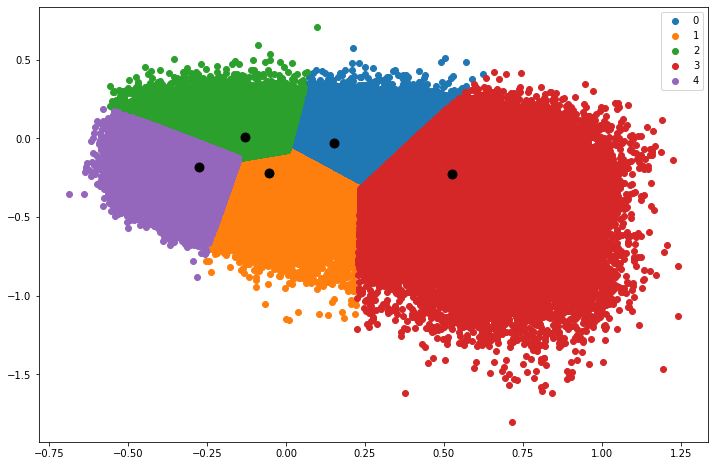

In [ ]:

# import matplotlib.pyplot as plt
# fig=plt.figure(figsize=(12,8))
# for i in range(5):
#     plt.scatter(pandas_predictions_df[pandas_predictions_df["prediction"] == i]['x'] , pandas_predictions_df[pandas_predictions_df["prediction"] == i]['y'], label=i)
#     plt.scatter(ctr[i][0] , ctr[i][1], s = 80, color = 'black')
# plt.legend()    
# plt.show()

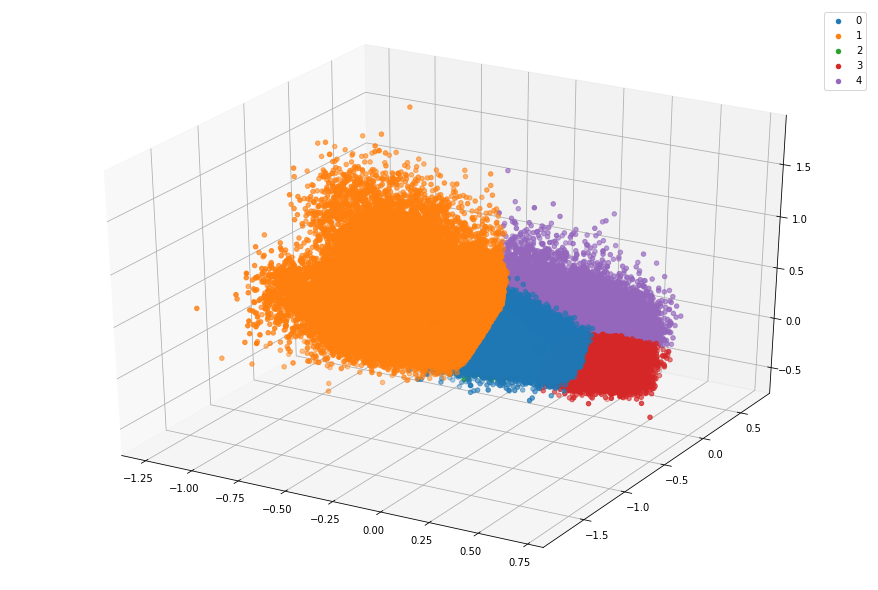

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
   
fig=plt.figure(figsize=(12,8))
ax=Axes3D(fig)
for i in range(5):
    ax.scatter(pandas_predictions_df[pandas_predictions_df["prediction"] == i]['x'] , pandas_predictions_df[pandas_predictions_df["prediction"] == i]['y'],  pandas_predictions_df[pandas_predictions_df["prediction"] == i]['z'], label=i)
for i in range(5):
    ax.scatter(ctr[i][0] , ctr[i][1] , ctr[i][2], s = 160, color = 'black')
plt.legend()    
plt.show()  

In [ ]:
# Just looking at spark parameters
print(spark.sparkContext.defaultParallelism)

2


In [ ]:
# More spark params
s = spark.sparkContext._jsc.sc().getExecutorMemoryStatus().keys()
print(s)
l = str(s).replace("Set(","").replace(")","").split(", ")
print(l)

d = set()
for i in l:
    d.add(i.split(":")[0])
print(len(d))

print(spark.sparkContext._jsc.sc().getExecutorMemoryStatus().size())

Set(492190d9606c:38029)
['492190d9606c:38029']
1
1


In [ ]:
# Get the spark config
spark.sparkContext._conf.getAll() 

[('spark.driver.host', 'f2e9c2339494'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '4g'),
 ('spark.driver.port', '40021'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1615496275942'),
 ('spark.app.name', 'word2vec'),
 ('spark.ui.showConsoleProgress', 'true')]

In [ ]:
# Look at vm os to get the number of cores
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0x1000065
cpu MHz		: 2250.000
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs spectre_v1 spectre_v2 spec_store_bypass
bogomips	: 4500.00
TLB size	: 307

In [ ]:
# Look at vm os to get memory size
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:          373764 kB
MemAvailable:   11164900 kB
Buffers:          115264 kB
Cached:         10581148 kB
SwapCached:            0 kB
Active:          4418788 kB
Inactive:        8105484 kB
Active(anon):    1701420 kB
Inactive(anon):      360 kB
Active(file):    2717368 kB
Inactive(file):  8105124 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               968 kB
Writeback:             0 kB
AnonPages:       1827760 kB
Mapped:           140948 kB
Shmem:              1124 kB
Slab:             336356 kB
SReclaimable:     294532 kB
SUnreclaim:        41824 kB
KernelStack:        5716 kB
PageTables:         9956 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    5137308 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1024 kB
AnonHugePages:   

In [4]:
# Look for the spark java process to get memory config
!ps -ef | grep java

root        1246      71 29 18:46 ?        00:00:07 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /content/spark-2.4.7-bin-hadoop2.7/conf/:/content/spark-2.4.7-bin-hadoop2.7/jars/* -Xmx5g org.apache.spark.deploy.SparkSubmit --conf spark.app.name=word2vec pyspark-shell
root        1326      71  0 18:47 ?        00:00:00 /bin/bash -c ps -ef | grep java
root        1328    1326  0 18:47 ?        00:00:00 grep java
